In [1]:
import os
import myutils

path2data = "./ego4d_data/v2"
sub_folder_jpg = "jpgs"
path2jpgs = os.path.join(path2data, sub_folder_jpg)

all_videos, all_labels, categories = myutils.get_vids(path2jpgs)
labels_dict = {c: i for i, c in enumerate(categories)}
labels_dict

c:\Users\povil\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'Car mechanic': 0, 'Farmer': 1, 'Playing cards': 2}

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

num_classes = len(categories)
unique_ids = [id_ for id_, label in zip(all_videos, all_labels) if labels_dict[label] < num_classes]
unique_labels = [label for id_, label in zip(all_videos, all_labels) if labels_dict[label] < num_classes]

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
train_idx, test_idx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[idx] for idx in train_idx]
train_labels = [unique_labels[idx] for idx in train_idx]

test_ids = [unique_ids[idx] for idx in test_idx]
test_labels = [unique_labels[ind] for ind in test_idx]

In [3]:
from torch.utils.data import Dataset, DataLoader
import glob
from PIL import Image
import torch
import numpy as np

class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform, num_frames = 16):
        self.transform = transform
        self.ids = ids
        self.labels = labels
        self.num_frames = num_frames
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        path2imgs = glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:self.num_frames]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frame = self.transform(frame)
            frames.append(frame)
            
        if len(frames) > 0:
            frames = torch.stack(frames)

        return (frames, label)

In [4]:
import torchvision.transforms as transforms
# ResNet
h, w = 112, 112

# Video MViT
# h, w = 224, 224

num_frames = 16

train_transformer = transforms.Compose([
    transforms.Resize((h,w)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),    
    transforms.ToTensor(),
    ])
train_ds = VideoDataset(ids = train_ids, labels = train_labels, transform = train_transformer, num_frames = num_frames)

test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            ]) 
test_ds = VideoDataset(ids = test_ids, labels = test_labels, transform = test_transformer, num_frames = num_frames)

In [5]:
batch_size = 3

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size = 2*batch_size, shuffle=False)

In [8]:
from torchvision import models
from torch import nn

# ResNet
# model = models.video.r3d_18(weights=models.video.R3D_18_Weights.DEFAULT)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, num_classes)

# ResNet 2+1
# model = models.video.r2plus1d_18(weights=models.video.R2Plus1D_18_Weights.DEFAULT)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, num_classes)

# ResNet MC
model = models.video.mc3_18(weights=models.video.MC3_18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

In [9]:
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
from torch import optim

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5)
os.makedirs("./models", exist_ok=True)

params_train={
    "num_epochs": 10,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    # "path2weights": "./models/weights_3dcnn.pt",
    "path2weights": "./models/weights_s3d.pt",
    "lr_scheduler": lr_scheduler
    }

model,loss_hist,metric_hist = myutils.train_val(model,params_train)

Copied best model weights!
Epoch 1/10
train loss: 0.857969, dev loss: 9.637255, accuracy: 22.56
----------
Copied best model weights!
Epoch 2/10
train loss: 0.792649, dev loss: 1.268934, accuracy: 60.90
----------
Copied best model weights!
Epoch 3/10
train loss: 0.839965, dev loss: 0.569402, accuracy: 81.95
----------
Epoch 4/10
train loss: 0.697416, dev loss: 0.620352, accuracy: 80.45
----------
Copied best model weights!
Epoch 5/10
train loss: 0.686102, dev loss: 0.372641, accuracy: 85.71
----------
Copied best model weights!
Epoch 6/10
train loss: 0.588839, dev loss: 0.369913, accuracy: 90.23
----------
Epoch 7/10
train loss: 0.586311, dev loss: 0.419937, accuracy: 87.22
----------
Epoch 8/10
train loss: 0.531878, dev loss: 0.614347, accuracy: 83.46
----------
Epoch 9/10
train loss: 0.558029, dev loss: 0.402854, accuracy: 88.72
----------
Epoch 10/10
train loss: 0.517024, dev loss: 12.596494, accuracy: 32.33
----------


In [14]:
loss_hist

{'train': [0.8579692145609586,
  0.7926490014443515,
  0.8399645098521884,
  0.6974159417403845,
  0.6861021691852595,
  0.5888393690104539,
  0.5863110383379706,
  0.5318776759724159,
  0.5580285780707097,
  0.5170241733504329],
 'val': [9.637254914920076,
  1.2689341790694044,
  0.5694019993893186,
  0.6203517703185404,
  0.37264098350266767,
  0.369912610830445,
  0.41993666140194563,
  0.6143474847750556,
  0.4028543044525878,
  12.596494222942152]}

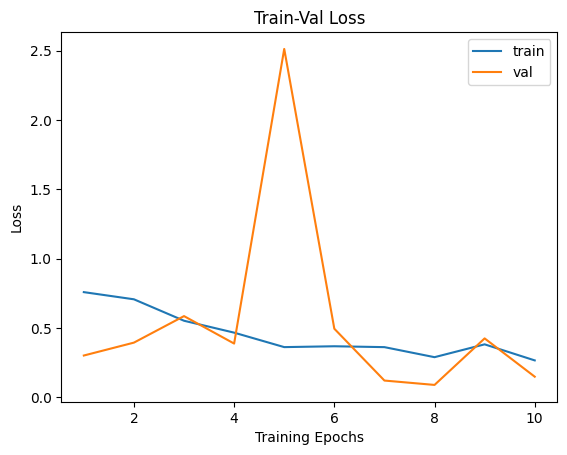

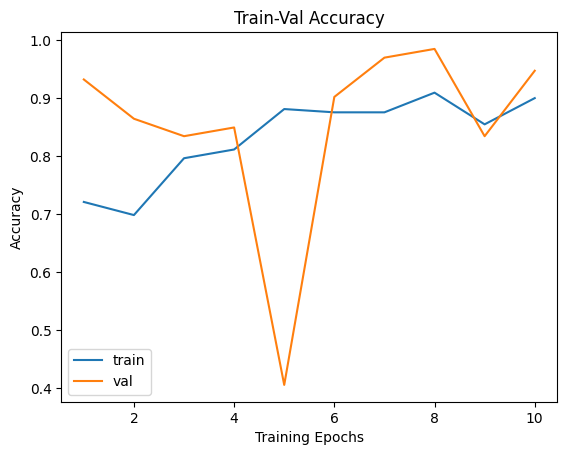

In [10]:
myutils.plot_loss(loss_hist, metric_hist)

In [11]:
metric_hist

{'train': [0.7212806026365348,
  0.6986817325800376,
  0.7966101694915254,
  0.8116760828625236,
  0.8813559322033898,
  0.8757062146892656,
  0.8757062146892656,
  0.9096045197740112,
  0.8549905838041432,
  0.9001883239171374],
 'val': [0.9323308270676691,
  0.8646616541353384,
  0.8345864661654135,
  0.849624060150376,
  0.40601503759398494,
  0.9022556390977443,
  0.9699248120300752,
  0.9849624060150376,
  0.8345864661654135,
  0.9473684210526315]}